# [Deep Learning for Vision Systems](https://www.manning.com/books/deep-learning-for-vision-systems?a_aid=compvisionbookcom&a_bid=90abff15) Book


## Chapter 6 Project: Transfer learning exercise

---
### 1. Import the libraries that we need


In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from keras.applications import mobilenet
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-whgavm3w because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### 2. Data preparation

In [2]:
train_path  = 'data/train'
valid_path  = 'data/valid'
test_path  = 'data/test'

In [3]:
train_batches = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(
    train_path, target_size=(224,224), batch_size=30)
valid_batches = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(
    valid_path, target_size=(224,224), batch_size=30)
test_batches = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(
    test_path, target_size=(224,224), batch_size=30)

Found 202 images belonging to 2 classes.
Found 103 images belonging to 2 classes.
Found 451 images belonging to 2 classes.


### 3. Download VGGNet and create our new network

![caption](transfer_network.png)

In [4]:
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3))
base_model.summary()

58889256/58889256 [==============================] - 9s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [5]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model

# use “get_layer” method to save the last layer of the network
# save the output of the last layer to be the input of the next layer
last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output

# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten()(last_output)

# add FC layer, which has 64 units and relu activation 
x = Dense(64, activation='relu', name='FC_2')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
# add our new softmax layer with 2 hidden units
x = Dense(2, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)

# print the new_model summary
new_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
new_model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
new_model.fit(train_batches, steps_per_epoch=4,
                   validation_data=valid_batches, validation_steps=2, epochs=20, verbose=2)

Epoch 1/20
4/4 - 23s - loss: 1.1687 - accuracy: 0.5089 - val_loss: 1.6160 - val_accuracy: 0.7833 - 23s/epoch - 6s/step
Epoch 2/20
4/4 - 2s - loss: 0.4060 - accuracy: 0.8333 - val_loss: 0.8305 - val_accuracy: 0.8167 - 2s/epoch - 435ms/step
Epoch 3/20
4/4 - 2s - loss: 0.2763 - accuracy: 0.8750 - val_loss: 0.4024 - val_accuracy: 0.9167 - 2s/epoch - 423ms/step
Epoch 4/20
4/4 - 2s - loss: 0.1789 - accuracy: 0.9000 - val_loss: 0.4092 - val_accuracy: 0.9000 - 2s/epoch - 427ms/step
Epoch 5/20
4/4 - 2s - loss: 0.0714 - accuracy: 0.9732 - val_loss: 0.3545 - val_accuracy: 0.9000 - 2s/epoch - 431ms/step
Epoch 6/20
4/4 - 2s - loss: 0.0867 - accuracy: 0.9732 - val_loss: 0.1857 - val_accuracy: 0.9667 - 2s/epoch - 420ms/step
Epoch 7/20
4/4 - 2s - loss: 0.0481 - accuracy: 1.0000 - val_loss: 0.2000 - val_accuracy: 0.9500 - 2s/epoch - 453ms/step
Epoch 8/20
4/4 - 2s - loss: 0.0781 - accuracy: 0.9750 - val_loss: 0.2250 - val_accuracy: 0.9500 - 2s/epoch - 430ms/step
Epoch 9/20
4/4 - 2s - loss: 0.0266 - accu

In [10]:
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets

In [11]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

test_files, test_targets = load_dataset('data/test')

In [33]:
from keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))

ImportError: cannot import name 'reshape' from 'keras.applications.vgg16' (/usr/local/lib/python3.8/dist-packages/keras/applications/vgg16.py)

In [26]:
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))

15/15 [==============================] - 17s 380ms/step - loss: 0.1260 - accuracy: 0.9401

Testing loss: 0.1260
Testing accuracy: 0.9401


In [27]:
# evaluate and print test accuracy
score = new_model.evaluate(test_tensors, test_targets)
print('\n', 'Test accuracy:', score[1])

15/15 [==============================] - 4s 246ms/step - loss: 0.1260 - accuracy: 0.9401

 Test accuracy: 0.9401330351829529


### The End

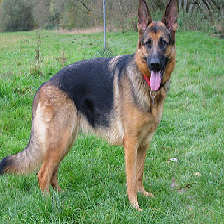

1/1 [==============================] - 0s 15ms/step
[[8.3124869e-06 9.9999166e-01]]
DOG (100.00%)
This is a DOG label we are 99.99916553497314% sure


In [62]:
# Load an image of our cat Kira and see if she is a dog or cat. We cant be sure...

img_path = 'data/dog.jpg'
image = load_img(img_path, target_size=(224, 224))
image.show()
#image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)
yhat = new_model.predict(image)
print(yhat)
np.argmax(yhat)
categories = {0:'CAT',1:'DOG'}
label = categories[np.argmax(yhat)]
print('This is a %s. We are (%.2f%%) sure of it' % (label, np.max(yhat)*100))
print('This is a {} label we are {}% sure'.format(label, np.max(yhat)*100))